In [4]:
import sys
sys.path.append("/kaggle/working/DUCK-Net")
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
!rm -rf /kaggle/working/DUCK-Net


In [2]:
!git clone https://github.com/khanhdat111/DUCK-Net.git

Cloning into 'DUCK-Net'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 131 (delta 59), reused 53 (delta 17), pack-reused 0
Receiving objects: 100% (131/131), 1.02 MiB | 3.81 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [5]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "DuckNet"  
path_kaggle = '/kaggle/working/'
progress_path = path_kaggle+ 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = path_kaggle+'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = path_kaggle+'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = path_kaggle+'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 100
min_loss_for_saving = 0.2

In [7]:
import os

a = '/kaggle/working/ProgressFull'
b = '/kaggle/working/ModelSaveTensorFlow'
os.makedirs(a, exist_ok=True)

In [ ]:
# Kiểm tra xem thư mục đã được tạo chưa
if os.path.exists(a):
    print("Thư mục mới đã được tạo thành công trong output!")
else:
    print("Đã có lỗi xảy ra khi tạo thư mục mới.")

In [ ]:
import shutil
a = '/kaggle/working/new_folder'
shutil.rmtree(a)


In [11]:
X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')


Resizing training images and masks: 1000


1000it [12:45,  1.31it/s]


In [12]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

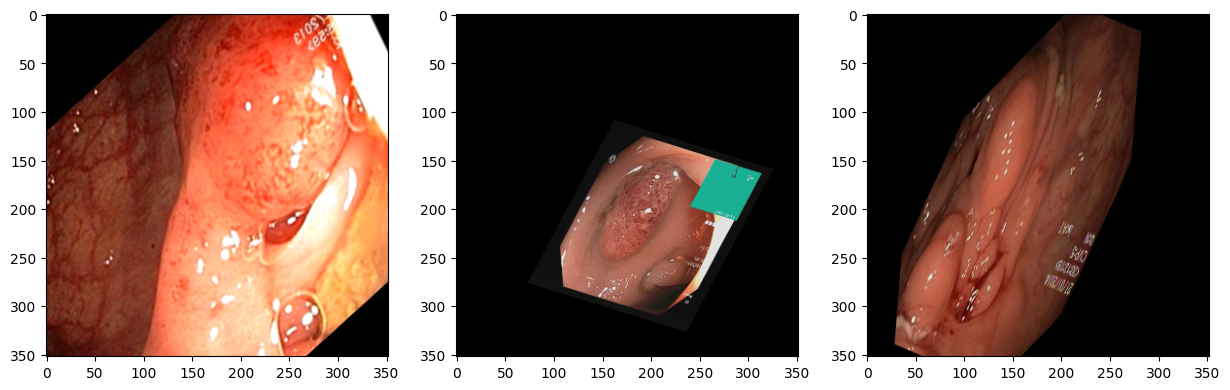

In [13]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

image_augmented, mask_augmented = augment_images()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_augmented[0]) 
plt.subplot(1, 3, 2)
plt.imshow(image_augmented[1]) 
plt.subplot(1, 3, 3)
plt.imshow(image_augmented[2]) 
plt.show()


In [14]:
# Creating the model

model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

Starting DUCK-Net


In [15]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Training the model
step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, 
              validation_data=(x_valid, y_valid), verbose=1, 
              callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:  
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
200/200 [==============================] - 301s 562ms/step - loss: 0.6233 - val_loss: 0.5961
Loss Validation: 0.59646785
Loss Test: 0.6345288
Training, epoch 1
Learning Rate: 0.0001
200/200 [==============================] - 107s 534ms/step - loss: 0.5952 - val_loss: 0.5849
Loss Validation: 0.58046484
Loss Test: 0.62052625
Training, epoch 2
Learning Rate: 0.0001
200/200 [==============================] - 107s 533ms/step - loss: 0.5727 - val_loss: 0.5565
Loss Validation: 0.5496989
Loss Test: 0.59112024
Training, epoch 3
Learning Rate: 0.0001
200/200 [==============================] - 107s 533ms/step - loss: 0.5443 - val_loss: 0.5292
Loss Validation: 0.5483916
Loss Test: 0.59452677
Training, epoch 4
Learning Rate: 0.0001
200/200 [==============================] - 107s 533ms/step - loss: 0.5338 - val_loss: 0.5418
Loss Validation: 0.5670892
Loss Test: 0.6121317
Training, epoch 5
Learning Rate: 0.0001
200/200 [==============================] - 107s 53

In [20]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = path_kaggle + 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')

Loading the model
25/25 [==============================] - 4s 142ms/step
Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_DuckNet_17_kvasir.txt
File done


In [19]:
import shutil
import os
from datetime import datetime

directory_to_zip = '/kaggle/working/ModelSaveTensorFlow/kvasir/DuckNet_filters_17_2023-12-06 07:45:02.277178'
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
zip_filename = f'DuckNet_files_{timestamp}.zip'
shutil.make_archive(zip_filename, 'zip', directory_to_zip)


/kaggle/working/DuckNet_files_2023-12-06_11-49-25.zip

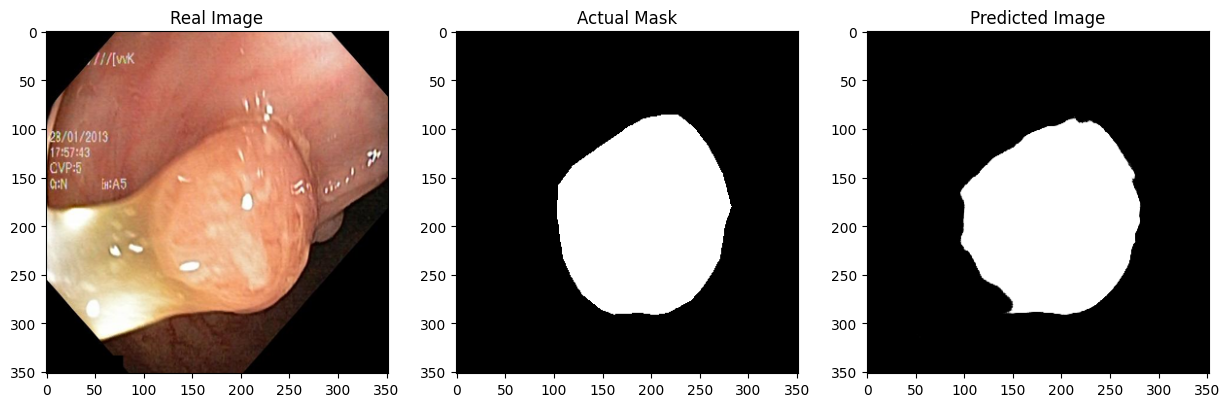

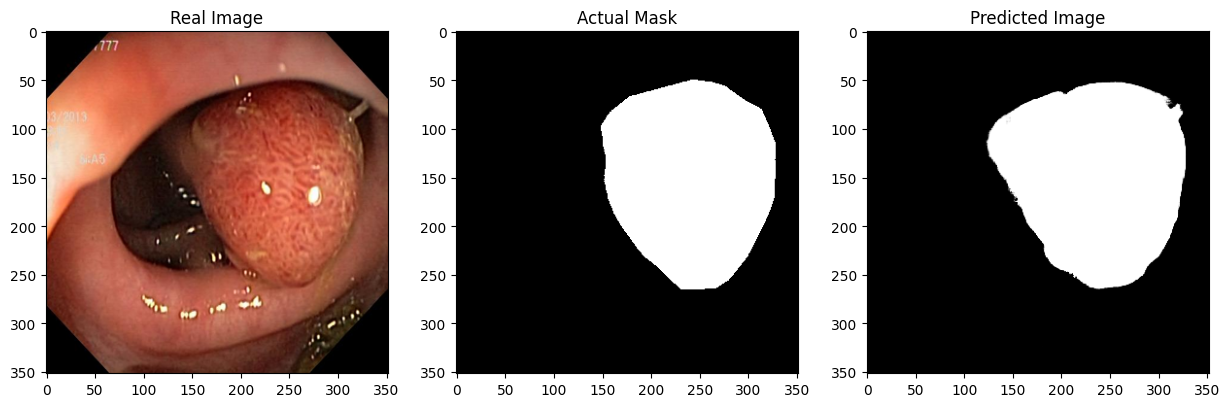

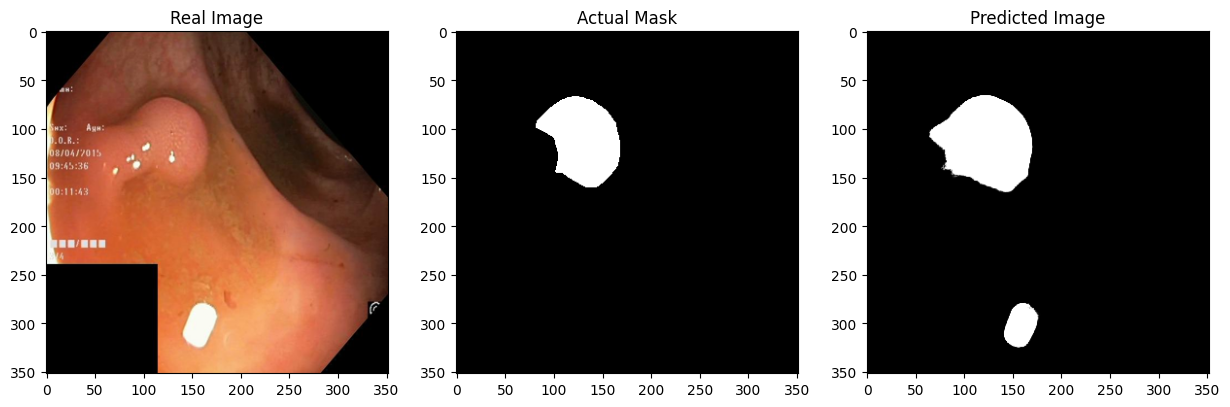

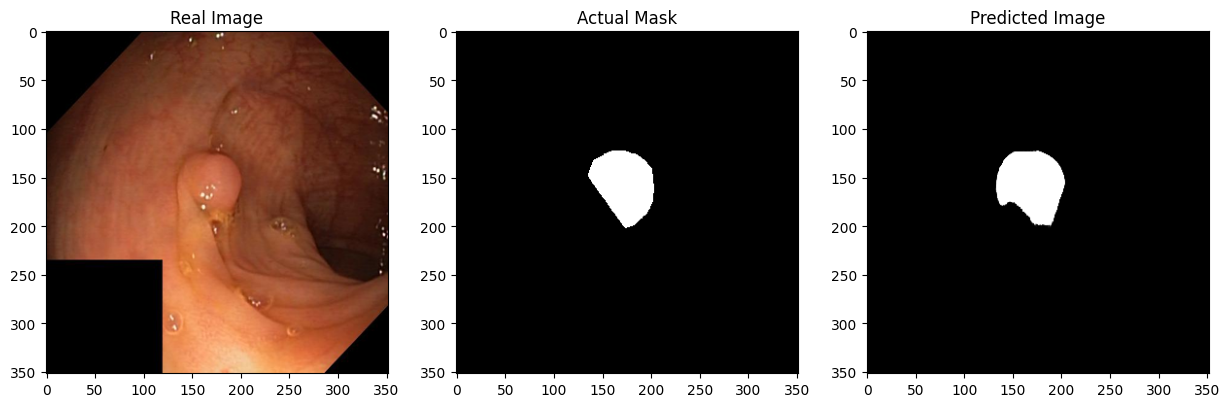

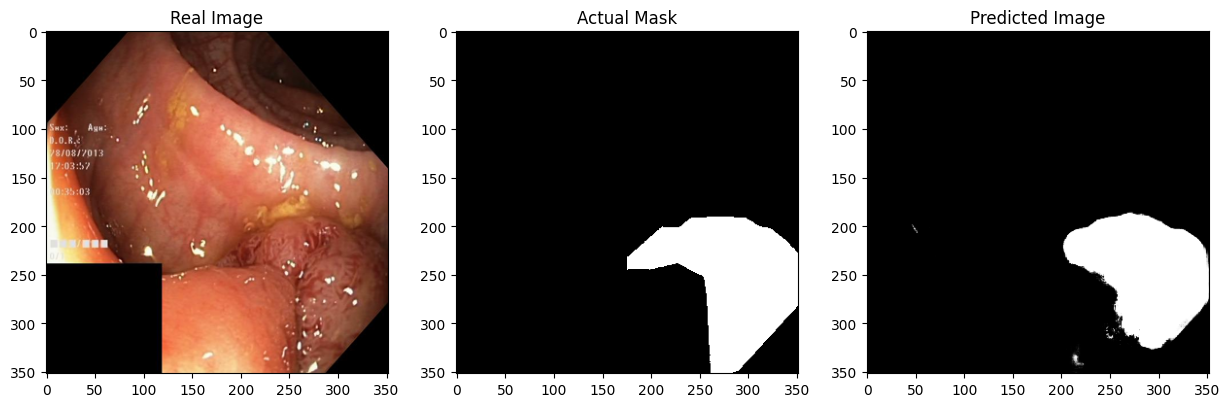

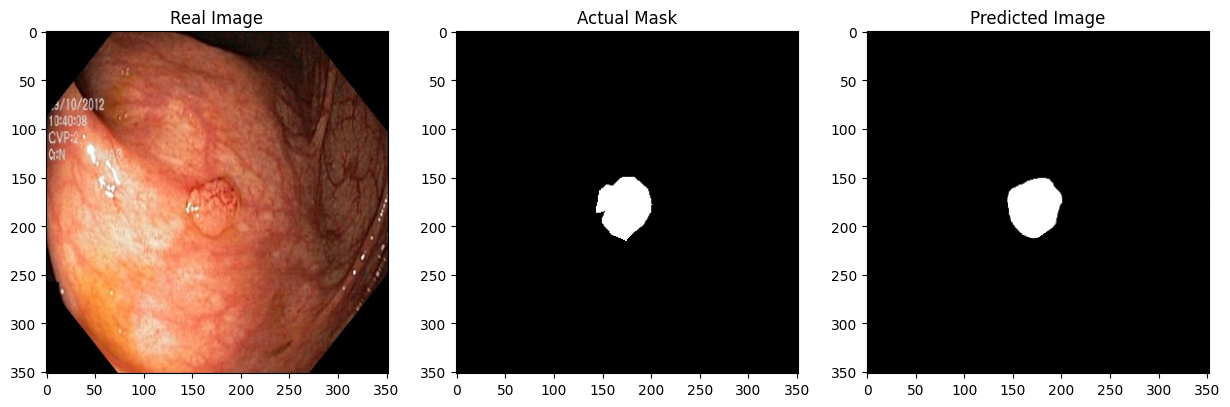

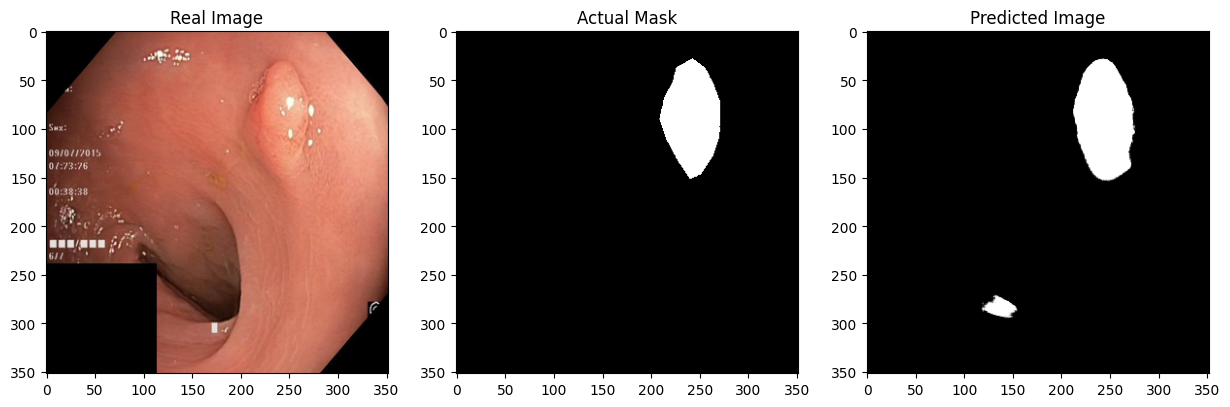

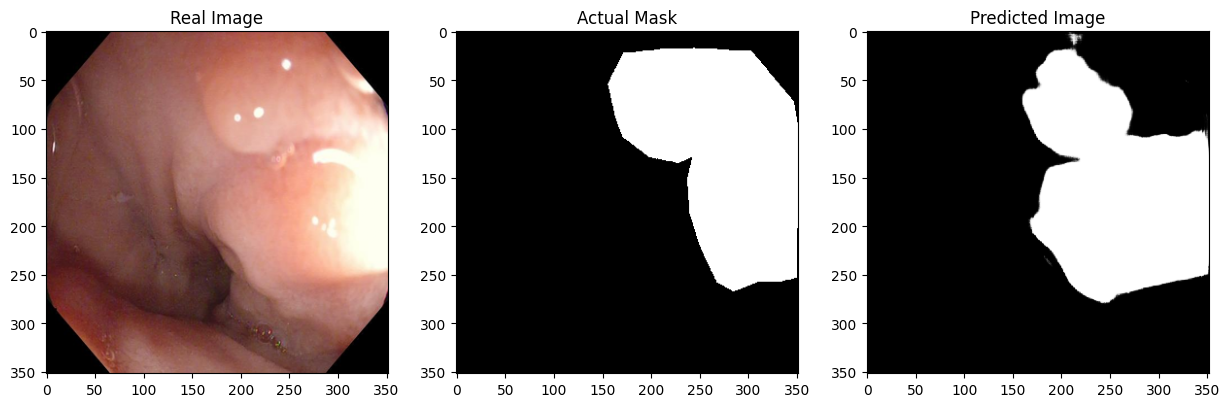

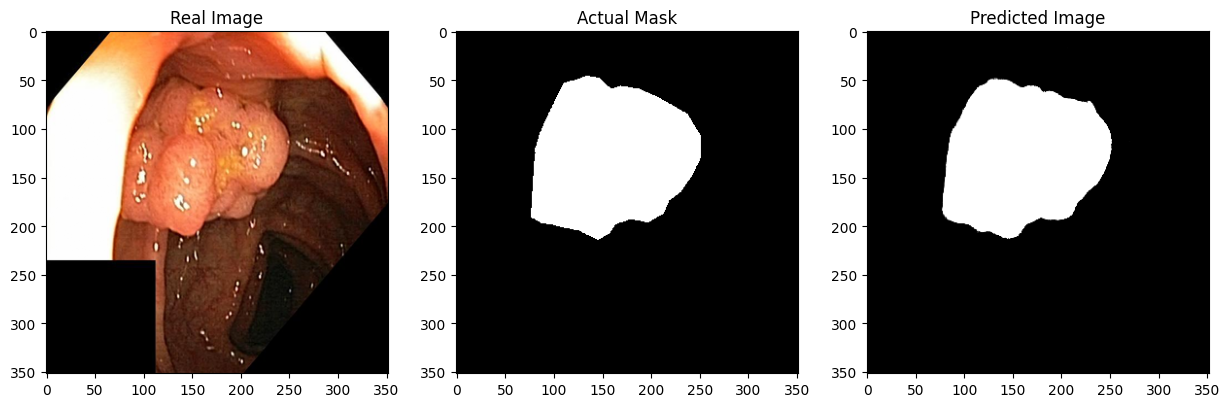

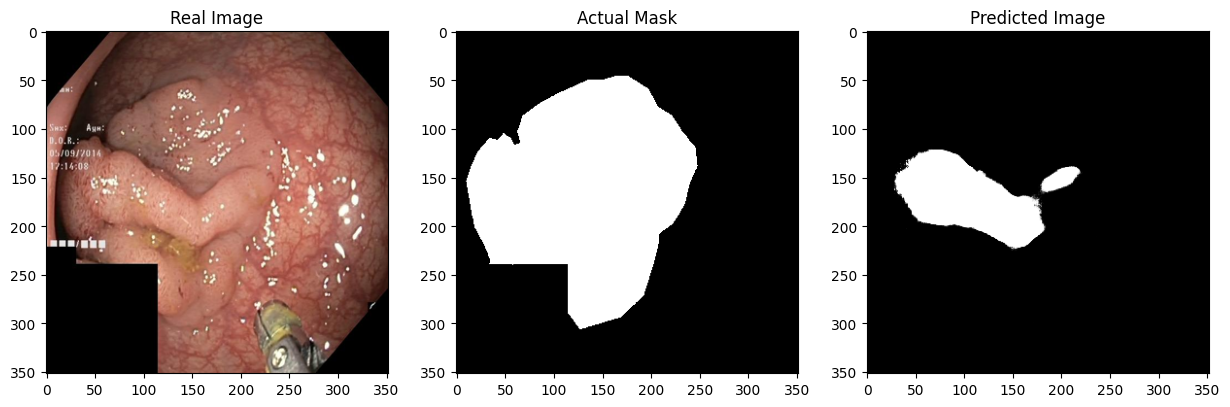

In [23]:
for i in range(10):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(x_valid[i])
    plt.title("Real Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_valid[i].squeeze(), cmap='gray')  
    plt.title("Actual Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction_valid[i].squeeze(), cmap='gray')
    plt.title("Predicted Image")
    
    plt.show()